In [1]:
import pandas as pd
import numpy as np
import cleaner
import re
import torch
import nltk

from tqdm import tqdm
from nltk import word_tokenize
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModel
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopwords_en = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

bert_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
bert_model = AutoModel.from_pretrained("microsoft/codebert-base")

tqdm.pandas()

[nltk_data] Downloading package stopwords to /home/ae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ae/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
TARGET = [
    'C', 'C#', 'C++', 'Dart', 'Elixir', 'Go', 'JSON', 'Java', 
    'Javascript', 'Julia', 'Kotlin', 'Markdown', 'Ruby', 'Rust', 'Python'
]

In [3]:
def clean_comments(contents, language) -> str:
    delimiters = cleaner.lang(language)

    if delimiters is not None:
        contents = cleaner.string(contents, *delimiters)

    return contents


def clean_extras(contents) -> str:
    contents = re.sub(r"[\r]", "", contents)
    contents = re.sub(r"\w{15,}", "", contents)
    contents = re.sub("[\n]{2,}", "\n", contents)
    contents = re.sub("[\t]{2,}", "\t", contents)
    contents = re.sub(r"[ ]+", " ", contents)

    contents = "\n".join(
        [line for line in contents.splitlines() if len(line.strip()) != 0]
    )

    return contents


def tokenize(source: str):
    tokens = bert_tokenizer.tokenize(
        source, return_tensors="pt", truncation=True, max_length=512
    )
    lemmas = [
        lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en
    ]
    return bert_tokenizer.convert_tokens_to_ids(lemmas)


def vectorize(tokens) -> np.ndarray:
    with torch.no_grad():
        outputs = bert_model(torch.tensor(tokens)[None, :])

    # We use the [CLS] token's embedding as the representation of the entire code snippet
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

    return cls_embedding

In [4]:
df = pd.concat([
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_0'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_1'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_2'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_3'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_4'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_5'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_6'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_7'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_8'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_9'),
])

In [5]:
len(df)

42501

In [6]:
list(df)

['language', 'source', 'tokens', 'vector']

<Axes: xlabel='language'>

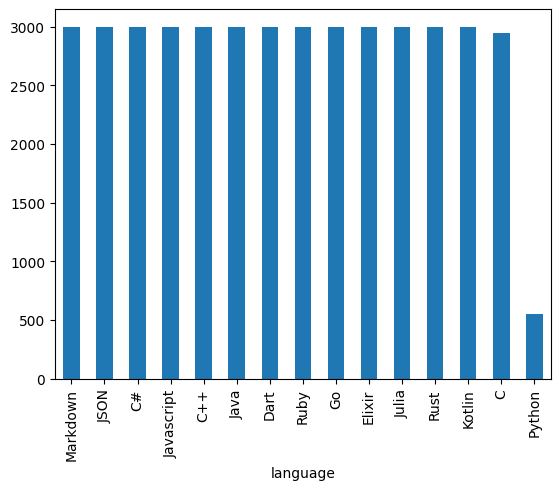

In [56]:
df['language'].value_counts().plot(kind = "bar")

In [73]:
mapper = {}
for i in range(len(TARGET)):
    mapper[TARGET[i]] = i

df['lang'] = df['language'].map(mapper)

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

X = df['vector']
# X = np.concatenate(X, axis=0).reshape(-1, 300)
X = np.vstack(X).reshape(-1, 768)
y = df['lang']

#stratify se asegura de mantener una proporcion entre las clases
X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.9, random_state=101, stratify=y)

In [110]:
from tensorflow.keras import Sequential, layers, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

early_stopping = callbacks.EarlyStopping(
    monitor = 'val_loss',
    restore_best_weights = True,
    patience = 3
)

In [111]:
y_train = to_categorical(y_train, len(TARGET))
y_test = to_categorical(y_test, len(TARGET))

In [112]:
model = Sequential()

# 300 neuronas de entrada conectadas todas con todas con 128
# model.add(layers.Input((300))
model.add(layers.Dense(units=768, activation='relu', input_dim=768))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=768, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=768, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(units=768, activation='relu'))
model.add(layers.Dropout(0.3))
# 3 de salida porque son 3 categoria
model.add(layers.Dense(len(TARGET), activation="softmax"))

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

model.summary()

/home/ae/repos/proyecto-pln/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 15)             │        11,535 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,373,903 (9.06 MB)

 Trainable params: 2,373,903 (9.06 MB)

 Non-trainable params: 0 (0.00 B)

In [113]:
history = model.fit(
    X_train, y_train,
    batch_size=50,
    epochs=1000,
    callbacks = [early_stopping],
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.0835 - loss: 2.7627 - val_accuracy: 0.3628 - val_loss: 2.5148
Epoch 2/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.1892 - loss: 2.5176 - val_accuracy: 0.4883 - val_loss: 1.9408
Epoch 3/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.3302 - loss: 2.0271 - val_accuracy: 0.6660 - val_loss: 1.3536
Epoch 4/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.4666 - loss: 1.5468 - val_accuracy: 0.7499 - val_loss: 1.0016
Epoch 5/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5656 - loss: 1.2466 - val_accuracy: 0.7783 - val_loss: 0.7837
Epoch 6/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6338 - loss: 1.0539 - val_accuracy: 0.7888 - val_loss: 0.6573
Epoch 7/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6957 - loss: 0.8974 - val_accuracy: 0.8209 - val_loss: 0.5559
Epoch 8/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7199 - loss: 0.7965 - val_accu

<Axes: >

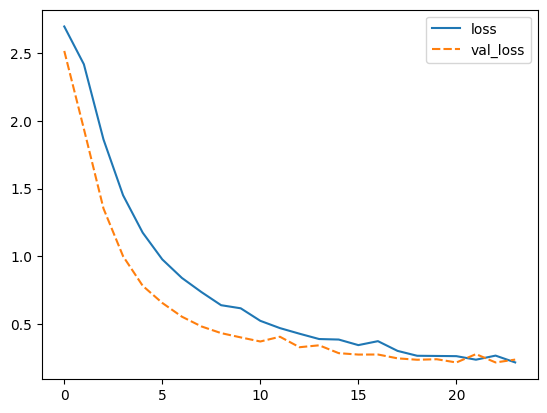

In [114]:
metrics = pd.DataFrame(history.history)
sns.lineplot(data=metrics[['loss', 'val_loss']])

<Axes: >

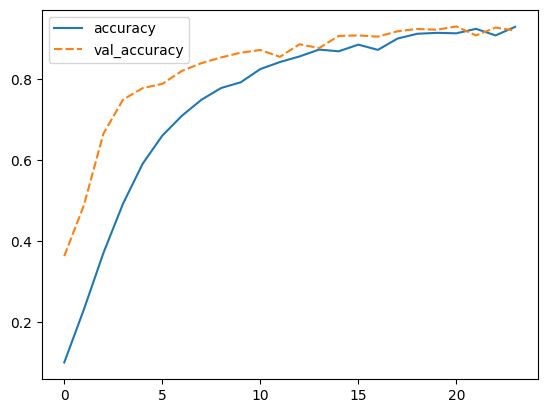

In [115]:
metrics = pd.DataFrame(history.history)
sns.lineplot(data=metrics[['accuracy', 'val_accuracy']])

In [116]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
y_true = np.argmax(y_test, axis =-1)

1196/1196 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [117]:
print(classification_report(y_true, y_pred, target_names=TARGET))

              precision    recall  f1-score   support

           C       0.81      0.83      0.82      2653
          C#       0.96      0.98      0.97      2700
         C++       0.82      0.79      0.81      2700
        Dart       0.88      0.90      0.89      2700
      Elixir       0.95      0.93      0.94      2700
          Go       0.98      0.99      0.99      2700
        JSON       0.96      1.00      0.98      2700
        Java       0.94      0.96      0.95      2700
  Javascript       0.93      0.91      0.92      2700
       Julia       0.98      0.92      0.95      2700
      Kotlin       0.98      0.97      0.98      2700
    Markdown       0.93      0.96      0.94      2700
        Ruby       0.93      0.98      0.96      2700
        Rust       0.97      0.95      0.96      2700
      Python       0.98      0.70      0.81       497

    accuracy                           0.93     38250
   macro avg       0.93      0.92      0.92     38250
weighted avg       0.93   

<Axes: >

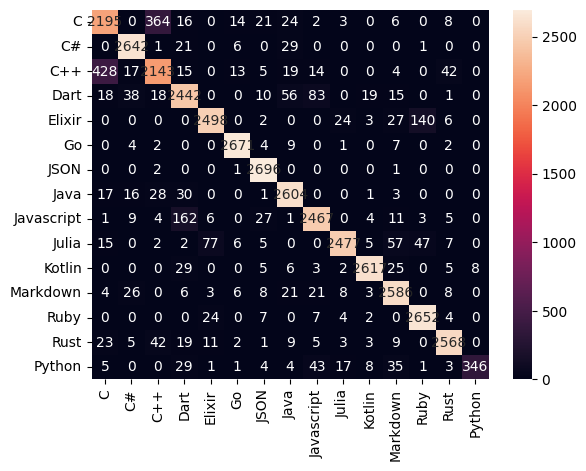

In [118]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='.0f', xticklabels=TARGET, yticklabels=TARGET)

In [1]:
def predecir(source, verbose = False, multi = [], single = []):
    
    cleaned = clean_extras(ccleaner.clean_string(source, multi, single), "")
    vec = vectorize(tokenize(cleaned)).reshape(1,-1)
    resultado = model.predict(vec, verbose = 0)

    if verbose:
        for i in range(len(TARGET)):
            print(f'{TARGET[i]: >10}: {round(resultado[0][i] * 100, 2): <2.2f} %')
    
    return TARGET[np.argmax(resultado)]